In [1]:
import pandas as pd

In [10]:
PERCENTILES = [x/10 for x in range(10)]

# Types count

```bash
rm stats/types.list

for pyc in `rpm -ql python3-libs | grep "39.pyc$"`; do
  python -m marshalparser -p $pyc | grep -E "^ +n=" | sed "s/.* \(TYPE_.*\) .*/\1/" >> stats/types.list;
done
cd stats
cat types.list | sort | uniq -c | sort -nr | awk '{print $2 "," $1}' > types.csv
```

In [2]:
types = pd.read_csv("types.csv", names=["type", "count"])
types

,type,count
0,TYPE_REF,194445
1,TYPE_SHORT_ASCII_INTERNED,71768
2,TYPE_SMALL_TUPLE,42742
3,TYPE_STRING,32805
4,TYPE_SHORT_ASCII,30899
5,TYPE_CODE,15886
6,TYPE_NONE,12532
7,TYPE_INT,5748
8,TYPE_ASCII,1820
9,TYPE_UNICODE,1658


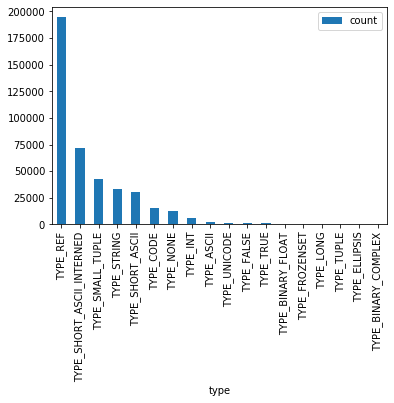

In [3]:
types.plot.bar(x="type", y="count")

# Statistics from marshalparser

Used command:

```shell
rm stats/statistics.csv
for pyc in `rpm -ql python3-libs | grep "39.pyc$"`; do python -m marshalparser -s $pyc >> stats/statistics.csv ; done
```

In [4]:
stats = pd.read_csv("statistics.csv", names=["type", "value"])
stats.head()

,type,value
0,TYPE_CODE_argcount,0
1,TYPE_CODE_posonlyargcount,0
2,TYPE_CODE_kwonlyargcount,0
3,TYPE_CODE_nlocals,0
4,TYPE_CODE_stacksize,4


## TYPE_REF

`TYPE_REF` currently has 4 bytes to store an index of an item ti referrences to. How many bytes/how big these indexes really are?

> In Fedora, we are already removing unused REF flags (the 7th bit) to make pyc files more reproducible so the numbers might be higher on other systems.

In [5]:
ref = stats[stats.type == "TYPE_REF"]
ref.sort_values(by="value", ascending=False)

,type,value
108028,TYPE_REF,970
107991,TYPE_REF,969
108080,TYPE_REF,969
107980,TYPE_REF,965
108075,TYPE_REF,964
...,...,...
31922,TYPE_REF,1
31867,TYPE_REF,1
31840,TYPE_REF,1
372232,TYPE_REF,1


In [6]:
ref.describe(percentiles=PERCENTILES)

,value
count,194445.000000
mean,87.152773
std,103.236681
min,1.000000
0%,1.000000
10%,10.000000
20%,16.000000
30%,23.000000
40%,32.000000
50%,46.000000


The highest index used in Python stdlib is 970 which is more than we can store in one byte but way less than 65536 we can store in two bytes. Also, 90 % of indexes are lower than 228.

In total, we can save 194445 * 2 = 388890 bytes

## TYPE_SHORT_ASCII[_INTERNED]

Short ASCII types use one byte to store their size so I don't expect a big room for improvements here.

In [7]:
short_ascii = stats[stats.type.str.startswith("TYPE_SHORT_ASCII")]
short_ascii.head()

,type,value
8,TYPE_SHORT_ASCII_INTERNED,13
9,TYPE_SHORT_ASCII_INTERNED,10
10,TYPE_SHORT_ASCII_INTERNED,8
11,TYPE_SHORT_ASCII_INTERNED,15
12,TYPE_SHORT_ASCII_INTERNED,14


In [8]:
short_ascii.sort_values(by="value", ascending=False)

,type,value
143771,TYPE_SHORT_ASCII,255
384840,TYPE_SHORT_ASCII,255
382264,TYPE_SHORT_ASCII,255
98897,TYPE_SHORT_ASCII,255
16046,TYPE_SHORT_ASCII,255
...,...,...
322054,TYPE_SHORT_ASCII_INTERNED,0
176399,TYPE_SHORT_ASCII_INTERNED,0
423477,TYPE_SHORT_ASCII_INTERNED,0
415785,TYPE_SHORT_ASCII_INTERNED,0


In [9]:
short_ascii.groupby("type").max()

,value
type,
TYPE_SHORT_ASCII,255
TYPE_SHORT_ASCII_INTERNED,63


In [11]:
short_ascii[short_ascii.type == "TYPE_SHORT_ASCII"].describe(percentiles=PERCENTILES)

,value
count,30899.000000
mean,33.053821
std,40.279772
min,1.000000
0%,1.000000
10%,5.000000
20%,9.000000
30%,14.000000
40%,18.000000
50%,22.000000


`TYPE_SHORT_ASCII` uses whole byte in some cases but `TYPE_SHORT_ASCII_INTERNED` doesn't -- the longest interned ASCII string is 63 bytes long and we need at least six bits to store this value so we are not able to combine it with anything else (like the TYPE byte).

## TYPE_INT

`TYPE_INT` uses four bytes.

In [13]:
int = stats[stats.type == "TYPE_INT"]
int.head()

,type,value
20,TYPE_INT,16
21,TYPE_INT,0
22,TYPE_INT,131072
23,TYPE_INT,262144
24,TYPE_INT,524288


In [14]:
int.sort_values(by="value", ascending=False)

,type,value
181215,TYPE_INT,4294967295
37705,TYPE_INT,4294967295
438447,TYPE_INT,4294967295
27012,TYPE_INT,4294967295
352465,TYPE_INT,4294967295
...,...,...
256026,TYPE_INT,0
101296,TYPE_INT,0
299599,TYPE_INT,0
101127,TYPE_INT,0


In [16]:
int.describe(percentiles=PERCENTILES)

,value
count,5.748000e+03
mean,2.483666e+08
std,9.926335e+08
min,0.000000e+00
0%,0.000000e+00
10%,1.000000e+00
20%,2.000000e+00
30%,9.000000e+00
40%,4.000000e+01
50%,1.210000e+02


The biggest number for 32 bits is 4294967295 which is exactly what we have in `TYPE_INT`. For other cases, we have `TYPE_LONG`.

## TYPE_CODE

Every code objects starts with a few integers: `argcount`, `posonlyargcount`, `kwonlyargcount`, `nlocals`, `stacksize`, `flags` and we have four bytes for each of them. Let's see what is the biggest number stored among them.

In [17]:
code = stats[stats.type.str.startswith("TYPE_CODE")]
code.head()

,type,value
0,TYPE_CODE_argcount,0
1,TYPE_CODE_posonlyargcount,0
2,TYPE_CODE_kwonlyargcount,0
3,TYPE_CODE_nlocals,0
4,TYPE_CODE_stacksize,4


In [18]:
code.sort_values(by="value", ascending=False)

,type,value
346315,TYPE_CODE_stacksize,2232
20889,TYPE_CODE_stacksize,687
21713,TYPE_CODE_stacksize,687
190999,TYPE_CODE_stacksize,651
105557,TYPE_CODE_stacksize,589
...,...,...
171766,TYPE_CODE_kwonlyargcount,0
341564,TYPE_CODE_argcount,0
341565,TYPE_CODE_posonlyargcount,0
341566,TYPE_CODE_kwonlyargcount,0


The highest value there is 2232 for the stack size of one code object -- this can fit in just two bytes. Let's see the highest values for all of those variables.

In [19]:
code.groupby("type").max()

,value
type,
TYPE_CODE_argcount,23
TYPE_CODE_flags,579
TYPE_CODE_kwonlyargcount,10
TYPE_CODE_nlocals,47
TYPE_CODE_posonlyargcount,4
TYPE_CODE_stacksize,2232


It might be possible to store 4 out of 6 values in one byte and the rest in two bytes but let's say we would use 2 bytes for all of them for consistency.

Then we would be able to save: 2 bytes x 6 variables x 15886 code objects = 190 632 bytes